# Actividad 2

## Descripción
A lo largo del curso, hemos explorado diferentes filtros espaciales, algunos suavizan las imágenes y otros que pareciera que le agregan ruido, así como algunos que se especializan en detectar bordes. La realidad es que todos estos filtros son de gran ayuda en muchos ámbitos, como en medicina, robótica, etc. En esta actividad, se profundiza sobre en la implementación de estos filtros, mostrando paso a paso el desarrollo de estos y algunos ejemplos.

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import os

In [5]:
class SpacialFilters(object):
    """
    Class that implements LP, HP filters with commons masks.
    In addition, it implements border detection.
    """
    
    BASE_DIR = os.getcwd()
    LP_FILTERS = {
        'average_filter': (np.ones(shape=(3,3))) * 1/9,
        'gaussian_filter': (np.array([1,2,1,2,4,2,1,2,1]).reshape(3,3)) * 1/16
    }
    HP_FILTERS = {
        'gradient': np.array([1,0,-1,1,0,-1,1,0,-1]).reshape(3,3),
        'laplacian': np.array([-1,-1,-1,-1,8,-1,-1,-1,-1]).reshape(3,3),
    }
    BORDER_DETECTION = {
        'prewitt_horizontal': np.array([1,1,1,0,0,0,-1,-1,-1]).reshape(3,3),
        'prewitt_vertical': np.array([-1,0,1,-1,0,1,-1,0,1]).reshape(3,3),
        'prewitt_45': np.array([-1,-1,0,-1,0,1,0,1,1]).reshape(3,3),
        'sobel_horizontal': np.array([1,2,1,0,0,0,-1,-2,-1]).reshape(3,3),
        'sobel_vertical': np.array([-1,0,1,-2,0,2,-1,0,1]).reshape(3,3),
        'sobel_45': np.array([-2,-1,0,-1,0,1,0,1,2]).reshape(3,3),
    }

    OPTIONS = (
        ('LP_FILTERS', LP_FILTERS.keys(), LP_FILTERS),
        ('HP_FILTERS', HP_FILTERS.keys(), HP_FILTERS),
        ('BORDER_DETECTION', BORDER_DETECTION.keys(), BORDER_DETECTION)
    )
    
    def __init__(self, img_path: str, weak_pixel=20, strong_pixel=180, low_threshold=0.01, high_threshold=0.04):
        self.low_threshold = low_threshold
        self.high_threshold = high_threshold
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.option = None
        # Image on gray scale (represented on a numpy ndarray)
        self.image = cv2.imread(self.BASE_DIR + img_path, cv2.IMREAD_GRAYSCALE)
        # image width
        self.width = int(self.image.shape[1])
        # image height
        self.height = int(self.image.shape[0])
        self.processed_image = None
        # Verify if the resolution is correct, else modify it
        self.resize_image()
        # Get the spacial filter (kernel or mask) to apply to the image
        self.kernel = self.get_filter()
        # Apply the kernel to the image
        self.apply_filter()


    def get_filter(self) -> np.array:
        """
        Display all the filters options to apply
        ...
        """
        # Dictionary to map the options with their masks
        valid_options = dict()
        is_valid = False
        print("Por favor, selecciona una opción.\n")
        # Show all the options
        for i in self.OPTIONS:
            print(i[0] + ":")
            for j in i[1]:
                raw_choice = j
                valid_options[raw_choice] = i[2][raw_choice]
                print("\t" + "- " + raw_choice)
        # Force to select a valid option
        while is_valid is False:
            option = input("\noption -> ")
            if option in valid_options.keys():
                is_valid = True
            else:
                print("Por favor ingresa una opción correcta.")
        kernel = valid_options[option]
        self.option = option

        return kernel


    def resize_image(self) -> None:
        """
        Resize the image to a resolution appropriate to work with
        ...
        """
        if self.height > 700:
            scale_percent = 700 / self.height
            # Get new dimension for the resized image
            self.width = int(self.width * scale_percent)
            self.height = int(self.height * scale_percent)
            dim = (self.width, self.height)

            # Resize image
            self.image = cv2.resize(self.image, dim, interpolation = cv2.INTER_AREA)


    def get_window_result(self, x: int, y: int, indexer: int) -> int:
        """
        Set the window where the median will be applied and return it
        ...

        Attributes
        -----------
        x : int
            x-coordinate
        y : int
            y-coordinate
        indexer : int
            help to get the new coordinates
        """
        y_start = y - indexer
        y_final = y + indexer + 1
        x_start = x - indexer
        x_final = x + indexer + 1        
        # slice the array in the window
        # given the image as an array, subtract an array from the main array
        window = self.image[y_start:y_final, x_start:x_final]
        # avoid RuntimeWarning : Mean of empty slice
        result = np.multiply(window, self.kernel)

        return int(np.sum(result, dtype = np.uint8))


    def apply_filter(self):
        """
        Apply a kernel to te image
        ...
        """                
        processed_image = np.zeros((self.height,self.width), dtype=np.uint8)
        # The indexer help to know where start to apply the T operator
        indexer = self.kernel.shape[1] // 2
        start_x = start_y = indexer
        final_x = self.width - indexer
        final_y = self.height - indexer
        # loop over the image array to get the window applying the kernel
        # and replace the current value on the processed image        
        for y in range(self.height):
            if start_y < y < final_y:
                for x in range(self.width):
                    if start_x < x < final_x:
                        result = self.get_window_result(x, y, indexer)
                        processed_image[y][x] = result

        self.processed_image = processed_image

    @staticmethod
    def non_max_suppression(image, d):
        """
        After getting gradient magnitude and direction, a full scan of image is done to remove any unwanted pixels which may not constitute the edge.
        For this, at every pixel, pixel is checked if it is a local maximum in its neighborhood in the direction of gradient.
        ...

        Attributes
        -----------
        :param image: numpy.array
        :param d: float
        :return: numpy.array
        """
        m, n = image.shape
        z = np.zeros((m,n), dtype=np.int32)
        angle = d * 180. / np.pi
        angle[angle < 0] += 180

        for i in range(1,m-1):
            for j in range(1,n-1):
                try:
                    q = 255
                    r = 255

                   #angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                        q = image[i, j+1]
                        r = image[i, j-1]
                    #angle 45
                    elif 22.5 <= angle[i, j] < 67.5:
                        q = image[i+1, j-1]
                        r = image[i-1, j+1]
                    #angle 90
                    elif 67.5 <= angle[i, j] < 112.5:
                        q = image[i+1, j]
                        r = image[i-1, j]
                    #angle 135
                    elif 112.5 <= angle[i, j] < 157.5:
                        q = image[i-1, j-1]
                        r = image[i+1, j+1]

                    if (image[i,j] >= q) and (image[i,j] >= r):
                        z[i,j] = image[i,j]
                    else:
                        z[i,j] = 0


                except IndexError as e:
                    pass

        return z


    def threshold(self, image):
        """
        This stage decides which are all edges are really edges and which are not. For this, we need two threshold values, minVal and maxVal.
        ...

        Attributes
        -----------
        :param image:
        :return:
        """

        high_threshold = image.max() * self.high_threshold;
        low_threshold = high_threshold * self.low_threshold;

        m, n = image.shape
        res = np.zeros((m,n), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        strong_i, strong_j = np.where(image >= high_threshold)
        zeros_i, zeros_j = np.where(image < low_threshold)

        weak_i, weak_j = np.where((image <= high_threshold) & (image >= low_threshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return res


    def hysteresis(self, image):
        """
        Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded
        ...

        Attributes
        ----------
        :param image:
        :return:
        """

        m, n = image.shape
        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1, m-1):
            for j in range(1, n-1):
                if image[i,j] == weak:
                    try:
                        if ((image[i+1, j-1] == strong) or (image[i+1, j] == strong) or (image[i+1, j+1] == strong)
                            or (image[i, j-1] == strong) or (image[i, j+1] == strong)
                            or (image[i-1, j-1] == strong) or (image[i-1, j] == strong) or (image[i-1, j+1] == strong)):
                            image[i, j] = strong
                        else:
                            image[i, j] = 0
                    except IndexError as e:
                        pass

        return image


    def canny_filter(self):
        """
        Apply the Canny filter. The Canny filter is one of the most widely used and effective transformations for edge detection.
        ...
        """
        # First, a Gaussian-type low-pass filter is applied to smooth the
        # image and reduces possible noise in the image.
        self.kernel = self.LP_FILTERS['gaussian_filter']
        self.apply_filter()

        # Save the original image to use later
        orginal_image = self.image

        # Replace the original image with the image with gaussian filter.
        # This is because in the apply_filter function we use the self.image as the starting point
        self.image = self.processed_image
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
        
        Ix = ndimage.convolve(self.image, Kx)
        Iy = ndimage.convolve(self.image, Ky)
        
        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
#         # First, a Gaussian-type low-pass filter is applied to smooth the
#         # image and reduces possible noise in the image.
#         self.kernel = self.LP_FILTERS['gaussian_filter']
#         self.apply_filter()

#         # Save the original image to use later
#         orginal_image = self.image

#         # Replace the original image with the image with gaussian filter.
#         # This is because in the apply_filter function we use the self.image as the starting point
#         self.image = self.processed_image

#         # calculates the gradient of the image in the different directions.
#         self.kernel = self.BORDER_DETECTION['sobel_horizontal']
#         self.apply_filter()
#         gx = self.processed_image
#         self.image = gx
#         self.kernel = self.BORDER_DETECTION['sobel_vertical']
#         self.apply_filter()
#         gy = self.processed_image
#         G = np.hypot(gx, gy)

#         # A transformation is applied to the non-maximum pixels which consists of putting
#         # to 0 the intensity value of the pixels that are not part of a local maximum.
#         G = G / G.max() * 255
#         theta = np.arctan2(gy, gx)

#         non_max_img = self.non_max_suppression(G, theta)
#         threshold_img = self.threshold(non_max_img)
#         processed_image = self.hysteresis(threshold_img)
#         edges = cv2.Canny(orginal_image,50,140)
#         self.processed_image = processed_image.astype(np.uint8)
        self.processed_image = G.astype(np.uint8)
#         self.processed_image = edges        
#         self.image = orginal_image
        self.option = "Canny"


    def show_results(self) -> None:
        """
        Plot the images
        """
        original_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        processed_image = cv2.cvtColor(self.processed_image, cv2.COLOR_BGR2RGB)
        images = [original_image, processed_image]
        titles = ["Original image", f"Processed image with {self.option} filter"]
        plt.figure(figsize=(35,35))
        for i in range(2):
          plt.subplot(3, 3, i+1)
          plt.imshow(images[i], vmin=0, vmax=255)
          plt.title(titles[i])
          plt.xticks([]),plt.yticks([])
        plt.show()

Por favor, selecciona una opción.

LP_FILTERS:
	- average_filter
	- gaussian_filter
HP_FILTERS:
	- gradient
	- laplacian
BORDER_DETECTION:
	- prewitt_horizontal
	- prewitt_vertical
	- prewitt_45
	- sobel_horizontal
	- sobel_vertical
	- sobel_45



option ->  gaussian_filter


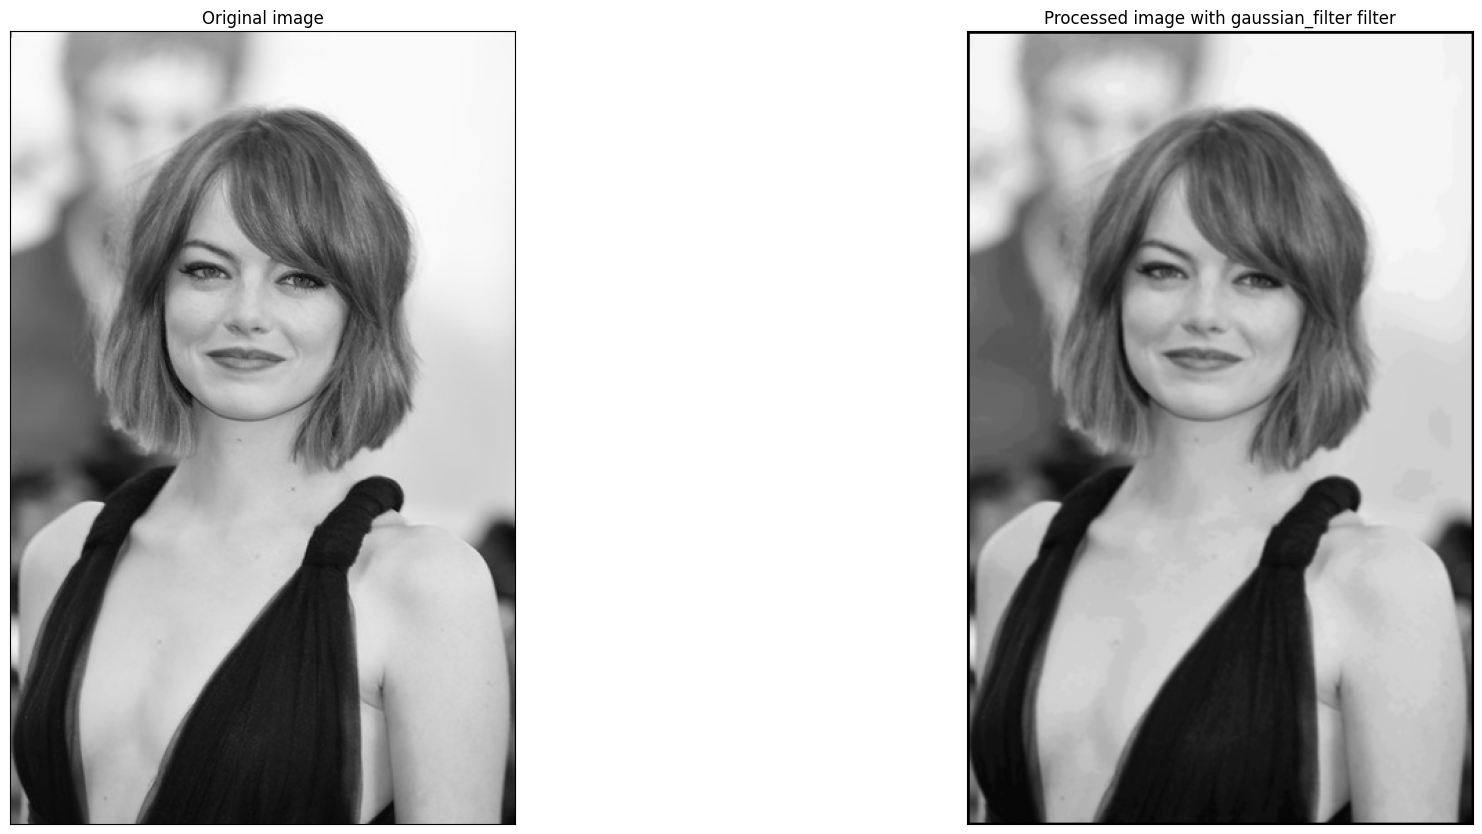

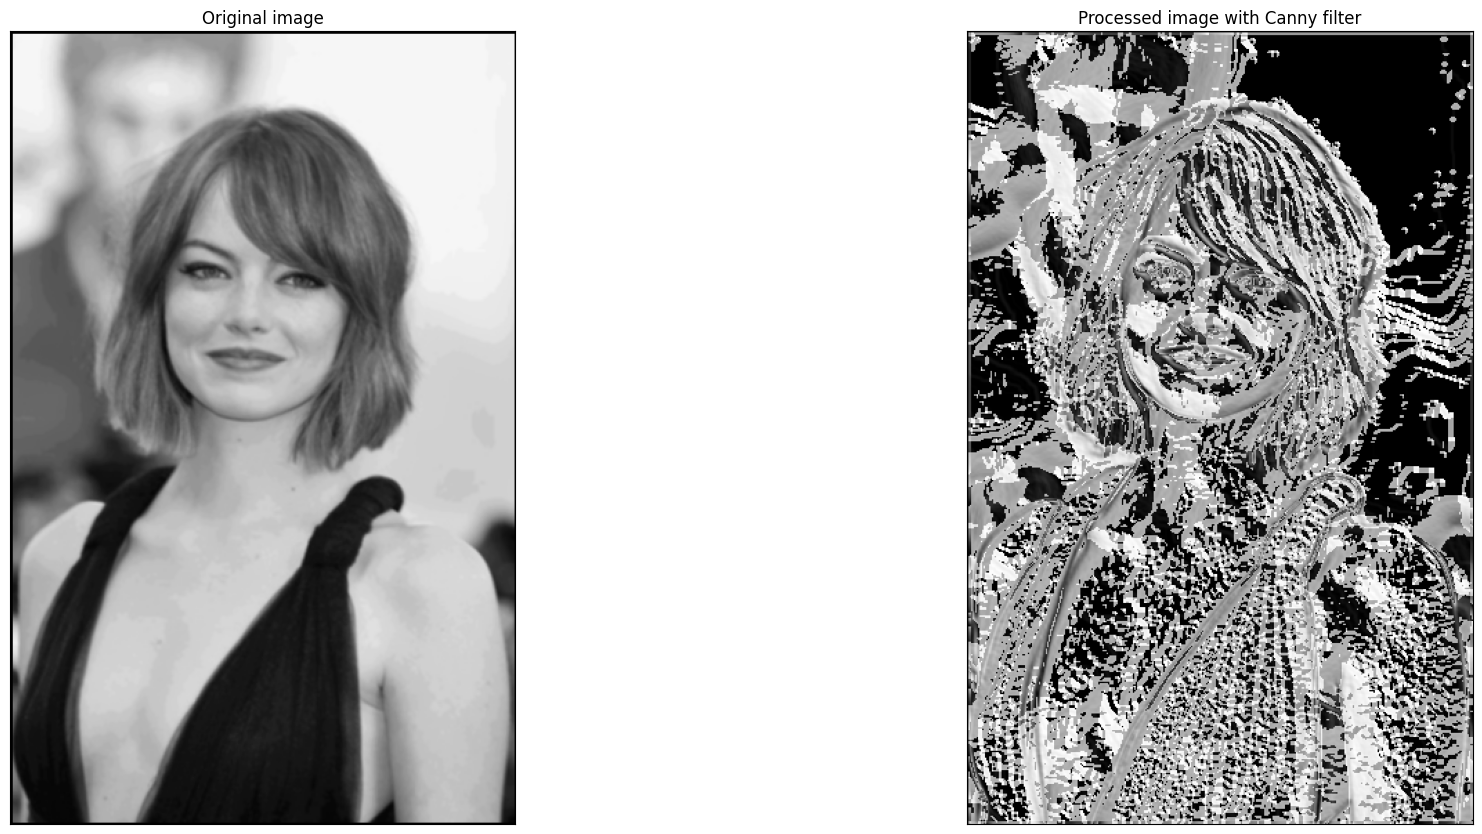

In [12]:
img = "/media/test.png"
act1 = SpacialFilters(img_path=img)
act1.show_results()
act1.canny_filter()
act1.show_results()

In [13]:
class MathematicalMorphology(object):
    """
    Class to apply the morphological operators given a structural element
    """
    BASE_DIR = os.getcwd()

    STRUCTURAL_ELEMENTS = {
        'square_structure': np.full(shape=(3, 3), fill_value=255),
        'cross structure': np.array([0,255,0,255,255,255,0,255,0]).reshape(3,3)
    }

    def __init__(self, img_path: str):
        # Image on gray scale (represented on a numpy ndarray)
        self.image = cv2.imread(self.BASE_DIR + img_path, cv2.IMREAD_GRAYSCALE)        
        # image width
        self.width = int(self.image.shape[1])
        # image height
        self.height = int(self.image.shape[0])
        self.processed_image = None
        # Verify if the resolution is correct, else modify it
        self.resize_image()
        # Get the image in binary form
        self.binary_image = self.get_binary_image()
        self.erode_img = self.erode()
        self.dilated_img = self.dilate()


    def resize_image(self) -> None:
        """
        Resize the image to a resolution appropriate to work with
        ...
        """
        if self.height > 150:
            scale_percent = 150 / self.height
            # Get new dimension for the resized image
            self.width = int(self.width * scale_percent)
            self.height = int(self.height * scale_percent)
            dim = (self.width, self.height)

            # Resize image
            self.image = cv2.resize(self.image, dim, interpolation = cv2.INTER_AREA)


    def get_binary_image(self, image=None, thresh_value=127) -> np.array:
        """
        Return a given image in binary form
        ...
        Attributes
        -----------
        :param image: np.array
        :param thresh_value: int
        :return: np.array
        """
        image = self.image if image is None else image
        color_1 = 255
        color_2 = 0
        initial_img = np.where((image <= thresh_value), image, color_1)
        final_img = np.where((initial_img > thresh_value), initial_img, color_2)

        return final_img


    def erode(self, image=None) -> np.array:
        """
        erode an image
        ...

        Attributes
        -----------
        :return: np.array
        """
        pad_width = 1
        image = self.binary_image if image is None else image
        # Extend the original image with 0s in order to loop with the structure
        extended_image = np.pad(array=image, pad_width=pad_width, mode='constant')
        # Get sub matrix according to the kernel size
        sub_matrix = np.array([
            extended_image[i:(i + 3), j:(j + 3)]
            for i in range(extended_image.shape[0] - (pad_width * 2)) for j in range(extended_image.shape[1] - (pad_width * 2))
        ])
        # replace the values either 255 or 0 by erode condition
        image_erode = np.array([255 if (i == self.STRUCTURAL_ELEMENTS['square_structure']).all() else 0 for i in sub_matrix])
        # obtain new matrix whose shape is equal to the original image size
        image_erode = image_erode.reshape(image.shape)
        
        return image_erode.astype(np.uint8)


    def dilate(self, image=None) -> np.array:
        """
        dilate an image
        ...

        Attributes
        -----------
        :return: np.array
        """
        pad_width = 1
        image = self.binary_image if image is None else image
        # Extend the original image with 0s in order to loop with the structure
        extended_image = np.pad(array=image, pad_width=pad_width, mode='constant')
        # Get sub matrix according to the kernel size
        sub_matrix = np.array([
            extended_image[i:(i + 3), j:(j + 3)]
            for i in range(extended_image.shape[0] - (pad_width * 2)) for j in range(extended_image.shape[1] - (pad_width * 2))
        ])

        # replace the values either 255 or 0 by dilation condition
        image_dilate = np.array([255 if (i == self.STRUCTURAL_ELEMENTS['square_structure']).any() else 0 for i in sub_matrix])
        # obtain new matrix whose shape is equal to the original image size
        image_dilate = image_dilate.reshape(image.shape)

        return image_dilate.astype(np.uint8)


    def open_filter(self) -> np.array:
        """
        Opening operation allows us to remove small blobs from an image.
        :return:
        """
        erode_image = self.erode_img
        final_image = self.dilate(image=erode_image)

        return final_image


    def closed_filter(self) -> np.array:
        """
        Closing operation is used to close holes inside of objects or for connecting components together.
        :return:
        """
        dilated_image = self.dilated_img
        final_image = self.erode(image=dilated_image)

        return final_image


    def show_results(self) -> None:
        """
        Plot the images
        """
        original_image = cv2.cvtColor(self.binary_image, cv2.COLOR_BGR2RGB)
        erode_image = cv2.cvtColor(self.erode_img, cv2.COLOR_BGR2RGB)
        dilated_image = cv2.cvtColor(self.dilated_img, cv2.COLOR_BGR2RGB)
        opening_image = cv2.cvtColor(self.open_filter(), cv2.COLOR_BGR2RGB)
        closed_image = cv2.cvtColor(self.closed_filter(), cv2.COLOR_BGR2RGB)
        images = [original_image, erode_image, dilated_image, opening_image, closed_image]
        titles = ["Original image", "Erode image", "Dilated image", "Opening operation", "Closing operation"]
        plt.figure(figsize=(35,35))
        for i in range(5):
          plt.subplot(3, 2, i+1)
          plt.imshow(images[i], vmin=0, vmax=255)
          plt.title(titles[i])
          plt.xticks([]),plt.yticks([])
        plt.show()



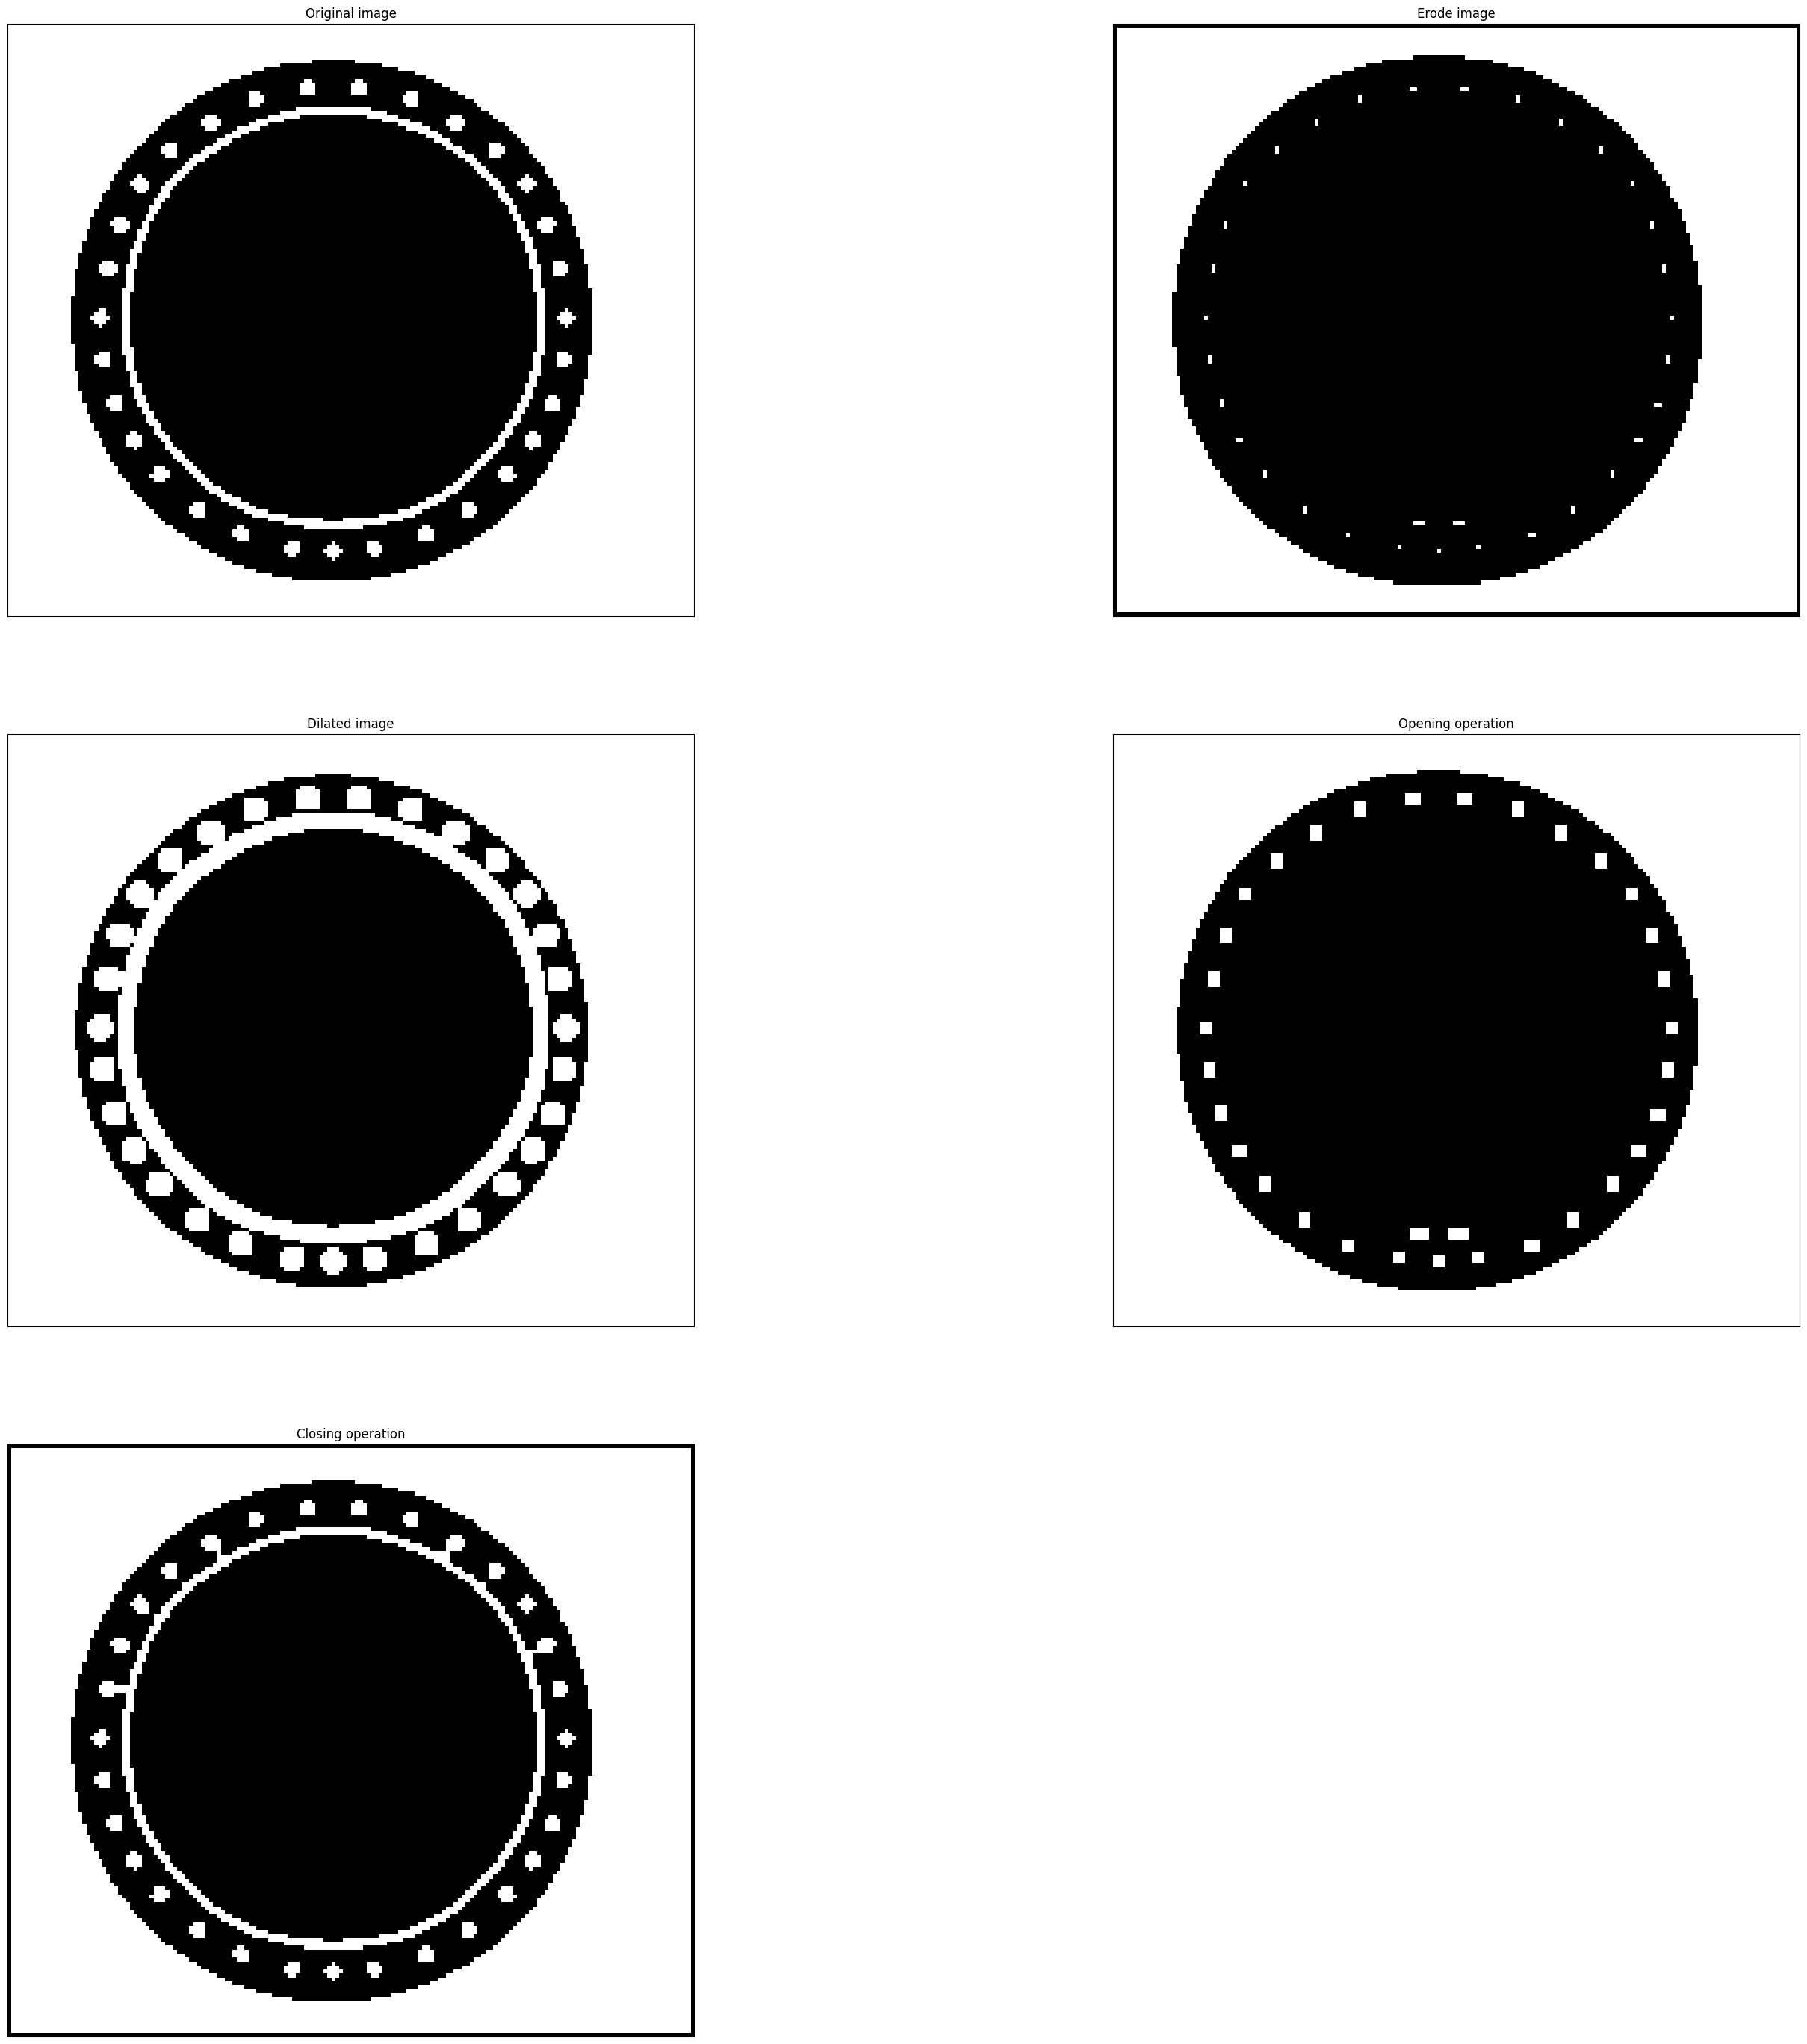

In [14]:
img = "/media/circle.png"
act2 = MathematicalMorphology(img_path=img)
act2.show_results()

In [1]:
from __future__ import print_function
import cv2 as cv
import argparse
max_lowThreshold = 100
window_name = 'Edge Map'
title_trackbar = 'Min Threshold:'
ratio = 3
kernel_size = 3
def CannyThreshold(val):
    low_threshold = val
    img_blur = cv.blur(src_gray, (3,3))
    detected_edges = cv.Canny(img_blur, low_threshold, low_threshold*ratio, kernel_size)
    mask = detected_edges != 0
    dst = src * (mask[:,:,None].astype(src.dtype))
    cv.imshow(window_name, dst)
parser = argparse.ArgumentParser(description='Code for Canny Edge Detector tutorial.')
parser.add_argument('--input', help='Path to input image.', default='./media/rubik.png')
args = parser.parse_args(args=[])
print(args)
src = cv.imread(cv.samples.findFile(args.input))
if src is None:
    print('Could not open or find the image: ', args.input)
    exit(0)
src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
cv.namedWindow(window_name)
cv.createTrackbar(title_trackbar, window_name , 0, max_lowThreshold, CannyThreshold)
CannyThreshold(0)
cv.waitKey()

Namespace(input='./media/rubik.png')


3